In [47]:
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import numpy as np

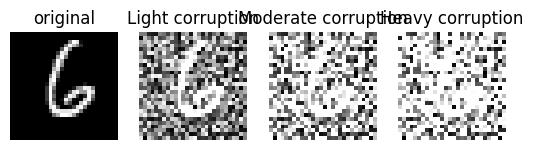

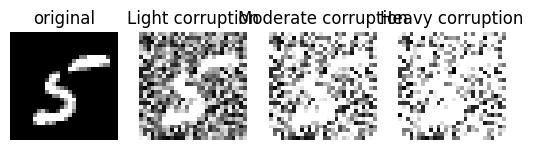

In [48]:
def load(fname: str):
    return np.loadtxt(fname).reshape((-1,784))

def plot_number(flat_array: np.ndarray, title=None, ax=plt):
    ax.imshow(flat_array.reshape((28,28)).T, 'gray', cm.NoNorm())
    ax.axis('off')
    if title:
        ax.set_title(title)

datasets = {
    'original': load('MNIST-5-6-subset.txt'),
    'Light corruption': load('MNIST-5-6-subset-Light-Corruption.txt'),
    'Moderate corruption': load('MNIST-5-6-subset-Moderate-Corruption.txt'),
    'Heavy corruption': load('MNIST-5-6-subset-Heavy-Corruption.txt'),
}

y = np.loadtxt('MNIST-5-6-Subset-Labels.txt', np.int32)

for idx in [4,8]:
    fig, axes = plt.subplots(1, 4)
    for title,ax in zip(datasets.keys(), axes.flatten()):
        plot_number(datasets[title][idx], ax=ax, title=title)

def knn_distances(X_train, X_val):
    distances = np.square(X_train[:,None,:] - X_val).sum(-1)
    return distances

def knn_predict(distances, k, y_train):
    idxs_closest_K = np.argsort(distances, 0)[:k]

    predictions = np.zeros(distances.shape[1], np.int64)
    predictions[(y_train[idxs_closest_K] == 5).sum(0) > k / 2] = 5
    predictions[(y_train[idxs_closest_K] == 6).sum(0) > k / 2] = 6
    predictions[predictions == 0] = y_train[idxs_closest_K[0,predictions==0]]

    return predictions

def make_train(X,y):
    return X[:100], y[:100]

def make_vals(X, y, n):
    return [(X[100+i*n:100+(i+1)*n], y[100+i*n:100+(i+1)*n]) for i in range(5)]

def train_and_validate(X, y, ns, Ks):
    X_train, y_train = make_train(X, y)
    val_losses = np.empty((len(ns), 5, len(Ks)))
    for _idx_n, n in enumerate(ns):
        for _idx_val, (X_val, y_val) in enumerate(make_vals(X, y, n)):
            distances = knn_distances(X_train, X_val)
            val_losses[_idx_n, _idx_val] = [np.mean([knn_predict(distances, K, y_train) != y_val]) for K in Ks]
    return val_losses

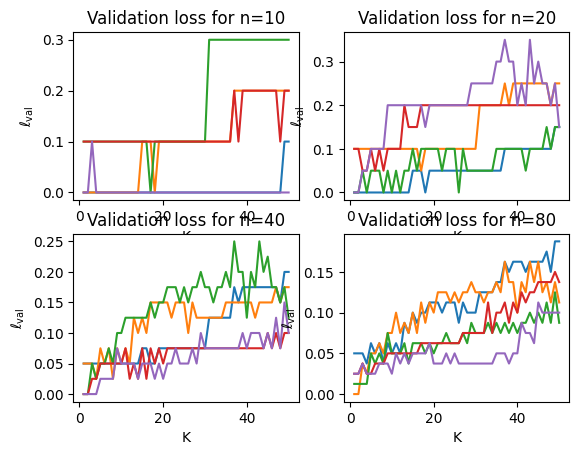

In [49]:
ns = [10, 20, 40, 80]
Ks = list(range(1, 51))
val_losses = train_and_validate(datasets['original'], y, ns=ns, Ks=Ks)

fig,axes = plt.subplots(2, 2)
for _val_losses, n, ax in zip(val_losses, ns, axes.flatten()):
    [ax.plot(Ks, __val_losses) for __val_losses in _val_losses]
    ax.set_title(f'Validation loss for n={n}')
    ax.set_xlabel('K')
    ax.set_ylabel(r'$\ell_\mathrm{val}$')

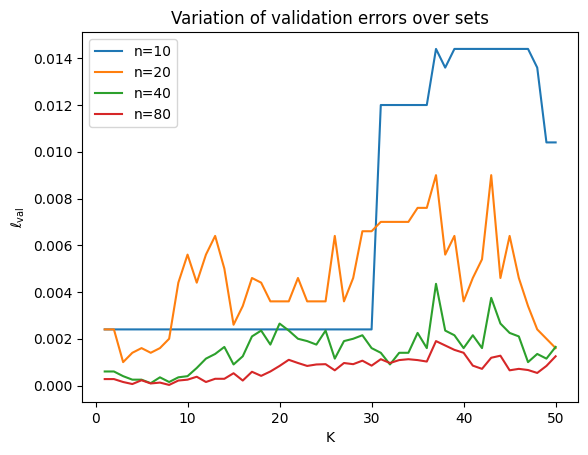

In [50]:
plt.figure()
for _val_losses, n, ax in zip(val_losses, ns, axes.flatten()):
    plt.plot(Ks, _val_losses.var(0), label=f'n={n}')
plt.title(f'Variation of validation errors over sets')
plt.xlabel('K')
plt.ylabel(r'$\ell_\mathrm{val}$')
_ = plt.legend()

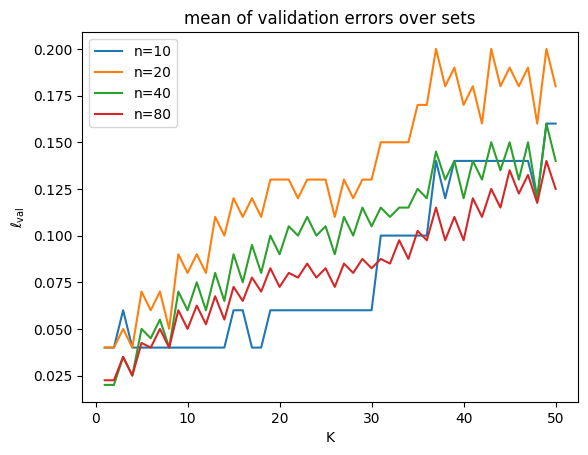

In [51]:

plt.figure()
for _val_losses, n, ax in zip(val_losses, ns, axes.flatten()):
    plt.plot(Ks, _val_losses.mean(0), label=f'n={n}')
plt.title(f'mean of validation errors over sets')
plt.xlabel('K')
plt.ylabel(r'$\ell_\mathrm{val}$')
_ = plt.legend()

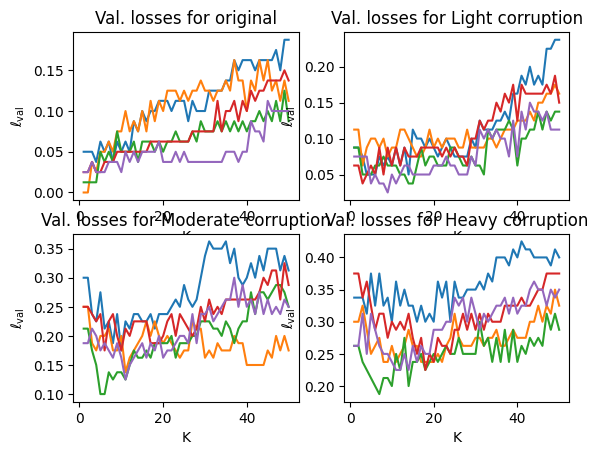

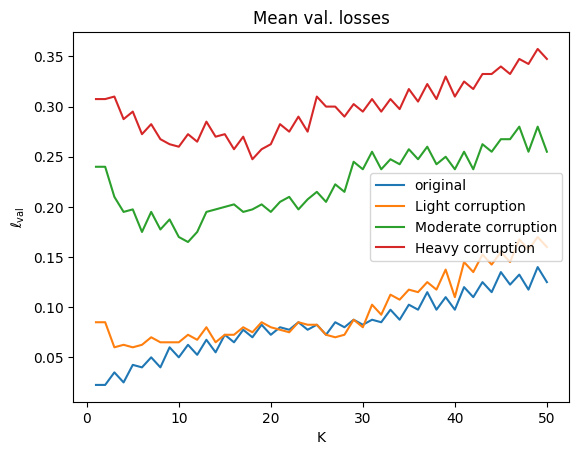

In [52]:
from cProfile import label


fig, axes = plt.subplots(2, 2)
fig_means, ax_means = plt.subplots()
for (title, X), ax in zip(datasets.items(), axes.flatten()):
    val_losses = train_and_validate(X, y, ns=[80], Ks=Ks)
    ax_means.plot(Ks, val_losses[0].mean(0), label=title)
    [ax.plot(Ks, _val_losses) for _val_losses in val_losses[0]]
    ax.set_title(f'Val. losses for {title}')
    ax.set_xlabel('K')
    ax.set_ylabel(r'$\ell_\mathrm{val}$')
ax_means.set_title('Mean val. losses')
ax_means.set_xlabel('K')
ax_means.set_ylabel(r'$\ell_\mathrm{val}$')
_ = ax_means.legend()